In [1]:
%matplotlib inline
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
local_dir = os.path.join("/DATA",os.environ.get("USER"),"MNIST_data")
os.makedirs(local_dir,mode=0o755, exist_ok=True)


## Dane MNIST


Dostęp do danych [MNIST](http://yann.lecun.com/exdb/mnist/) jest ułatwniony w tensorflow poprzez moduł `tensorflow.examples.tutorials.mnist`. 

Można korzystać w sposób bezpośredni, albo przez `next_batch`, przykłady:

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(local_dir, one_hot=True)

Extracting /DATA/marcin.kostur/MNIST_data/train-images-idx3-ubyte.gz
Extracting /DATA/marcin.kostur/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /DATA/marcin.kostur/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /DATA/marcin.kostur/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
mnist.train.images.shape,mnist.test.images.shape,mnist.test.labels.shape

((55000, 784), (10000, 784), (10000, 10))

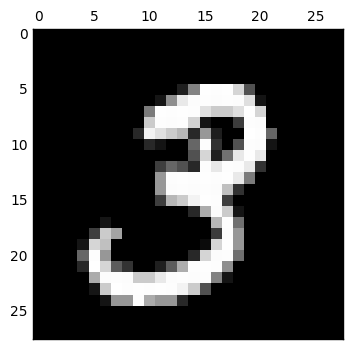

In [5]:
plt.matshow(mnist.train.images[1,:].reshape(28,28),cmap='gray')

In [6]:
mnist.train.labels[1]

array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.])

In [7]:
mnist.train.next_batch(100)[1].shape

(100, 10)

In [8]:
mnist.train.images[123:124,:].shape

(1, 784)

In [9]:
mnist.train._num_examples

55000

In [10]:
mnist.train.next_batch

<bound method DataSet.next_batch of <tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f8327229cc0>>

## Budowa sieci (grafu obliczeniowego w tf)

 - obrazek reprezentowany jak wektor o długości 784.
 - budujemy jednowarstwową sieć 
 - warstwa wyjściowa  to 10 percetpronów
 - używamy funkcji softmax na wyjsciu (zamiast np. max).
 - `x` jest placeholderem dla pewnej nieustalonej liczby obrazków 

In [11]:
x = tf.placeholder(tf.float32, [None, 784])
#W = tf.Variable(tf.zeros([784, 10]))
W = tf.Variable( tf.truncated_normal([784, 10], stddev=0.1,dtype=tf.float32) )
b = tf.Variable(tf.zeros([10]))

Sieć jest definiowana jedną linią w tensorflow:

[Jak działa softmax?](#Jak-działa-softmax)

In [12]:
y = tf.nn.softmax(tf.matmul(x, W) + b)
#y = tf.nn.sigmoid(tf.matmul(x, W) + b)
#y = tf.nn.relu(tf.matmul(x, W) + b)
#y = tf.matmul(x, W) + b

Niech `y_` będzie zawieram poprawą odpowiedź (label), jako funkcję kosztu możemy zastosować cross entropię lub zwykła normę.

In [13]:
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
norm =  tf.norm(y_ - y)


In [14]:
train_step = tf.train.GradientDescentOptimizer(0.05).minimize(cross_entropy)


In [15]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

In [16]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [17]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.per_process_gpu_memory_fraction = 0.05
sess = tf.InteractiveSession(config=config)
tf.global_variables_initializer().run()

Przetestujmy przepuszczenie jednego obrazka przez sieć i obliczenie np. normy:

**Uwaga** - na wejsciu musi być tensor z dwoma indeskami, więc jeśli chcemy przetworzyc dokładnie jeden obrazek to zamiast shate (784,) trzeba dać (1,784). Sprawdź różnicę między:

    mnist.train.images[123:124,:].shape
    mnist.train.images[123,:].shape

In [18]:
sess.run(y,feed_dict={x: mnist.train.images[123:124,:], y_: mnist.train.labels[123:124,:]})

array([[ 0.10745675,  0.18702491,  0.05121084,  0.02974638,  0.23540315,
         0.07742552,  0.05379809,  0.11787368,  0.04683366,  0.09322695]], dtype=float32)

In [19]:
sess.run(norm,feed_dict={x: mnist.train.images[123:124,:], y_: mnist.train.labels[123:124,:]})

0.8746801

## Learning !

 - `tf.global_variables_initializer().run()` resetuje wszystkie `W` i `b` - jeśli chcemy kontynuować uczenie to trzeba to wyrzucić.
 - stosujemy Stochastic Gradient Descent dla 100 szt. danych w jednym kroku


In [20]:
%%time 
hst = []
hst2 = []
tf.global_variables_initializer().run()
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    hst2.append(  sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys}))
    hst.append(  sess.run(accuracy, feed_dict={x: batch_xs, y_: batch_ys}))


CPU times: user 9.79 s, sys: 1.39 s, total: 11.2 s
Wall time: 4.55 s


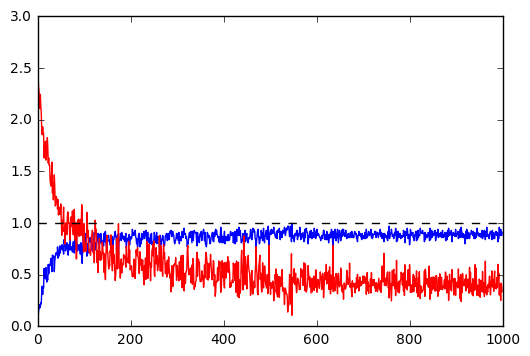

In [21]:
plt.plot(hst)
plt.plot(hst2,'r')
plt.axhline(1.0,color='black', linestyle='--')


## Własności wytrenowanej sieci

 - dokładność na **całym** zbiorze trenującym 
 - dokładność na danych których sieć nigdy nie widziała ( mamy 10tys. danych w `mnist.test` )

In [22]:
print(sess.run(accuracy, feed_dict={x: mnist.train.images, y_: mnist.train.labels}))

0.891128


In [23]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9017


## Klasyfikowanie wytrenowaną siecią.

Ponieważ sieć jest prosta możemy łatwo wykonać klasyfikaję danego obrazka wykorzystując operacje w numpy:

In [25]:
W_local,b_local = W.eval(),b.eval()

In [26]:
ith = 21
x_in = mnist.test.images[ith]
print(np.argmax(np.dot(x_in,W_local)+b_local))
print(np.argmax(mnist.test.labels[ith]))

6
6


Zobaczmy ten obrazek:

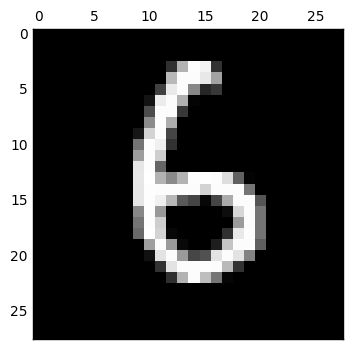

In [27]:
plt.matshow(x_in.reshape(28,28),cmap='gray')

In [28]:
errors = [] 
for ith in range(mnist.test.num_examples):
    x_in = mnist.test.images[ith]
    prediction = np.argmax(np.dot(x_in,W_local)+b_local)
    label = np.argmax(mnist.test.labels[ith])
    if prediction!=label:
        #print(ith,prediction,label)
        errors.append([prediction,label,x_in.reshape(28,28)]) 
print( len(errors))

983


In [29]:
from time import sleep

In [30]:
#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display
def DisplayArray(a, fmt='png', rng=[0,1]):
    """Display an array as a picture."""
    a = (a - rng[0])/float(rng[1] - rng[0])*255
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [31]:
for er in errors[:12]:
    print("zamiast ",er[1], "sieć odczytała",er[0],end="")
    DisplayArray(er[2])
    sleep(0.25)
    clear_output(wait=True)

zamiast  6 sieć odczytała 5

## Jak działa softmax 
 

In [32]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

In [33]:
p = np.array([0.1,1,1,3,5,6])
print(p)
print(softmax(p),np.sum(softmax(p)))

[ 0.1  1.   1.   3.   5.   6. ]
[ 0.00191051  0.00469909  0.00469909  0.03472188  0.25656189  0.69740753] 1.0
